In [1]:
cd ../src

C:\Users\jeong\Desktop\python\action-recognition-practice\src


In [2]:
import numpy as np
import processing.nia2019v1 as nia
import matplotlib.pyplot as plt
import processing
import math
import os
import random
from IPython.display import display, HTML
from matplotlib import animation
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
raw_path = "../data/nia2019v1/raw"
processed_path = "../data/nia2019v1/processed"

In [3]:
metadata_list = nia.get_all_metadata(raw_path)
actions = [act for meta in metadata_list for obj in meta.objects for act in obj.actions]

In [4]:
def visualize_actions(actions):
    names = nia.get_action_names_from_action_list(actions)
    cnt = { name: 0 for name in names }
    
    for action in actions:
        cnt[action.name] += 1

    cnt = sorted(cnt.items(), key=lambda x: x[1], reverse=True)
    
    x = list(map(lambda x: x[0], cnt))
    height = list(map(lambda x: x[1], cnt))

    print("# number of clips by action:")
    for item in cnt:
        print(f"{item[0]}: {item[1]}")

    plt.title("number of clips by action")
    plt.bar(x, height)
    plt.show()

# 분석

# number of clips by action:
totter: 2480
stop and go: 731
pulling: 691
threaten: 551
falldown: 480
touching: 363
pushing: 249
drop: 247
sitdown: 229
carring: 214
punching: 95
stealing: 47
around: 39
hugging: 24
running: 24
throwing: 6
standing: 1


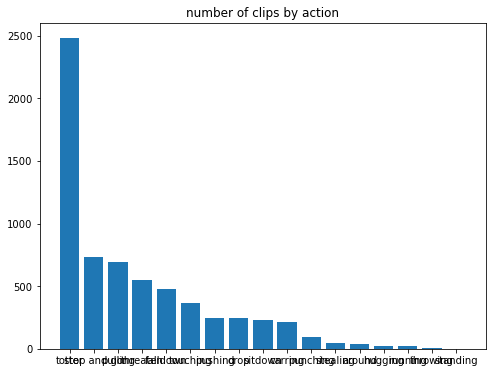

In [5]:
visualize_actions(actions)

# number of clips by action:
totter: 70
pulling: 41
falldown: 41
drop: 24
touching: 23
sitdown: 7
pushing: 5
threaten: 4
punching: 4
carring: 3
stealing: 1


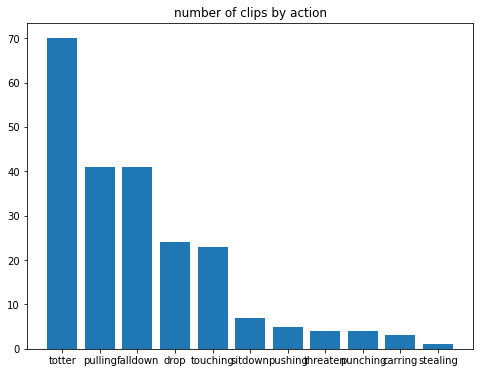

In [6]:
# 원하는 프레임 수에 맞는 길이의 액션만 추출
fps = 3
frames = 16
duration = math.ceil(frames / fps)

actions_filtered = [a for a in actions if a.duration <= duration + (1/fps) and a.duration > duration]
visualize_actions(actions_filtered)

# 데이터셋 생성

In [7]:
action_names_selected = ["falldown", "pulling", "totter", "drop", "touching"]
actions_filtered = [a for a in actions_filtered if a.name in action_names_selected]

In [8]:
from tqdm import tqdm
samples = []
for action in tqdm(actions_filtered):
    clip = nia.create_clip_from_action(action, fps=fps, crop_size=(340, 340))
    samples.append((action.name, clip))

100%|████████████████████████████████████████████████████████████████████████████████| 152/152 [01:22<00:00,  1.84it/s]


In [9]:
clips = np.array([sample[1][:,0:9,:,:] for sample in samples])
targets = [sample[0] for sample in samples]
clips.shape

(152, 3, 9, 340, 340)

# 저장

In [10]:
np.savez_compressed(os.path.join(processed_path, "falldown pulling totter"), clips=clips, targets=targets)

# 불러오기

In [11]:
loaded = np.load(os.path.join(processed_path, "falldown pulling totter.npz"))
clips = loaded['clips']
targets = loaded['targets']

# 테스트

In [12]:
def play_as_video(clip, target):
    video = np.einsum("cthw->thwc", clip)
    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])
    plt.title(target)
    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, frames=video.shape[0],
                                interval=1000/3)
    return HTML(anim.to_html5_video())

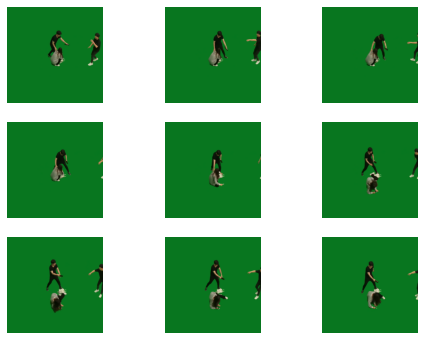

In [13]:
clip = np.einsum('cthw->thwc', clips[0])
frame_cnt = clip.shape[0]
grid_size = math.ceil(math.sqrt(frame_cnt))
for i, frame in enumerate(clip):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(frame)
    plt.axis('off')
plt.show()

In [15]:
for _ in range(30):
    idx = random.randrange(len(clips))
    display(play_as_video(clips[idx], targets[idx]))